In [48]:
!pip install tensorflow

     -------------------------------------- 376.9/376.9 MB 7.0 MB/s eta 0:00:00
     ---------------------------------------- 133.7/133.7 kB ? eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB ? eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 23.3 MB/s eta 0:00:00
     ------------------------------------- 413.4/413.4 kB 13.0 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 21.5 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 21.7 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 23.8 MB/s eta 0:00:00
     --------------------------------------- 24.4/24.4 MB 19.8 MB/s eta 0:00:00
     -------------------------------------- 127.8/127.8 kB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 3.8/3.8 MB 22.0 MB/s eta 0:00:00
     ------------------------------------- 240.7/240.7 kB

In [53]:
!pip install pydot

In [57]:
!pip install pydotplus

     -------------------------------------- 278.7/278.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24578 sha256=772e43d603ce18c8efe6195ad4d9bb0f2d0f885144b064a354b9a5980d490af2
  Stored in directory: c:\users\richard.huang\appdata\local\pip\cache\wheels\5c\94\1f\953aa60af58ef512e5256e538ff0772c340229e5996ac51fd6
Successfully built pydotplus


In [1]:
!pip install graphviz

     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00


In [22]:
import chess
import chess.engine
import random
import numpy as np
import pydot
from tqdm import tqdm
import zstandard
import io
import json
import graphviz

In [2]:
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)
  # print(f'{depth} random moves generated.')

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board

# def stockfish(board, depth, player:chess.Color):
#   with chess.engine.SimpleEngine.popen_uci(r"C:\Users\Richard.Huang\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe") as sf:
#     result = sf.analyse(board, chess.engine.Limit(depth=depth))
#     if player:
#       score = result['score'].white().score()
#     else:
#       score = result['score'].black().score()
#   return score

def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci(r"C:\Users\Richard.Huang\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe") as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
  return score

board = random_board()
print(board)

print(stockfish(board, 3))
for move in board.legal_moves:
  print(move)
  print(move.to_square)
  print(move.promotion)

. . . . k . . .
. . . . . . b .
. . P . b . p .
. . . . p . . r
. . . r P . P .
. p N . . P . p
. . . B . . . .
. . . K . . R Q
155
e8f8
61
None
e8d8
59
None
e8f7
53
None
e8e7
52
None
g7h8
63
None
g7f8
61
None
g7h6
47
None
g7f6
45
None
e6g8
62
None
e6c8
58
None
e6f7
53
None
e6d7
51
None
e6f5
37
None
e6d5
35
None
e6g4
30
None
e6c4
26
None
h5h8
63
None
h5h7
55
None
h5h6
47
None
h5g5
38
None
h5f5
37
None
h5h4
31
None
d4d8
59
None
d4d7
51
None
d4d6
43
None
d4d5
35
None
d4e4
28
None
d4c4
26
None
d4b4
25
None
d4a4
24
None
d4d3
19
None
d4d2
11
None
g6g5
38
None
h3h2
15
None
b3b2
9
None


In [143]:
def board_encoder(board):
  encoded_board = np.zeros([8,8,15]).astype(np.int8)
  fen = board.fen()
  fen_field = fen.split(' ')
  PiecePlacement = fen_field[0].split('/')
  piece_dict = {"R":0, "N":1, "B":2, "Q":3, "K":4, "P":5,
                "r":6, "n":7, "b":8, "q":9, "k":10, "p":11
                }
  for rank in range(8):
    pieces = ''
    for c in PiecePlacement[rank]:
      if c.isnumeric():
        pieces += '-'*int(c)
      else:
        pieces += c
    for file in range(8):
      if pieces[file] != '-':
        encoded_board[rank, file, piece_dict[pieces[file]]] = 1
  # plane 12 encodes all the legal moves of white
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
    encoded_board[7-np.unravel_index(move.to_square, (8,8))[0], np.unravel_index(move.to_square, (8,8))[1], 12] = 1
  # plane 13 encodes all the legal moves of black
  board.turn = chess.BLACK
  for move in board.legal_moves:
    encoded_board[7-np.unravel_index(move.to_square, (8,8))[0], np.unravel_index(move.to_square, (8,8))[1], 13] = 1
  board.turn = aux
  # plane 14 encodes the current player to move: white is 1, black is 0
  if fen_field[1] == 'w':
    encoded_board[:,:,14] = 1
  else:
    encoded_board[:,:,14] = 0
  return encoded_board

In [77]:
def board_encoder_alphazero(fen):
  # Encode the board state for alpha network
  # AlphaZero takes the last T time-step.
  # In this code, it only consider the current state.
  # The input to the alpha network is an N x N x (MT + L) image stack.
  # In this case, T=1, N = 8, M = 14,
  # 6x2 for the indication of the presence of player's pieces
  # (rook, knight, bishop, king, queen, pawn), 2 for repititions
  # L=7, 1 denotes current player's color, 1 denotes the total move count,
  # 2 denote P1's castling right, king's side and queen's side
  # 2 denote P2's castling right, king's side and queen's side
  # 1 denotes no-progress (half-move) count (50 moves without capture and pawn
  # move is an automatic draw).
  encoded_board = np.zeros([8,8,21]).astype(int)
  fen_field = fen.split(' ')

  PiecePlacement = fen_field[0].split('/')
  # The board is oriented to the perspective of the current player
  # noted as P1
  if fen_field[1] == 'w':
    piece_dict = {"R":0, "N":1, "B":2, "Q":3, "K":4, "P":5,
                "r":6, "n":7, "b":8, "q":9, "k":10, "p":11
                }
    encoded_board[:,:,14] = 0 # white is coded as 0
    # castling right
    if 'K' in fen_field[2]:
      encoded_board[:,:,16] = 1
    if 'Q' in fen_field[2]:
      encoded_board[:,:,17] = 1
    if 'k' in fen_field[2]:
      encoded_board[:,:,18] = 1
    if 'q' in fen_field[2]:
      encoded_board[:,:,19] = 1
  else:
    piece_dict = {"r":0, "n":1, "b":2, "q":3, "k":4, "p":5,
                "R":6, "N":7, "B":8, "Q":9, "K":10, "P":11
                }
    encoded_board[:,:,14] = 1 # black is coded as 1
    #castling right
    if 'k' in fen_field[2]:
      encoded_board[:,:,16] = 1
    if 'q' in fen_field[2]:
      encoded_board[:,:,17] = 1
    if 'K' in fen_field[2]:
      encoded_board[:,:,18] = 1
    if 'Q' in fen_field[2]:
      encoded_board[:,:,19] = 1

  for rank in range(8):
    pieces = ''
    for c in PiecePlacement[rank]:
      if c.isnumeric():
        pieces += '-'*int(c)
      else:
        pieces += c
    for file in range(8):
      if pieces[file] != '-':
        encoded_board[rank, file, piece_dict[pieces[file]]] = 1

  # two repitition planes:
  # The first repetition plane will be a plane where all the entries are 1's
  # if the position is being repeated for the first time. Else 0's.
  # The second repetition plane will be a plane where all the entries are 1's
  # if the current position is being repeated for the second time. Else 0's.
  # Since we are only considering one state, both planes will be zero.
  # Future development to add past time-step.
  encoded_board[:,:,12] = 0
  encoded_board[:,:,13] = 0

  # the following planes are constant-valued planes denoting the current state
  # time-step invariant
  encoded_board[:,:,15] = fen_field[-1] # total move count
  encoded_board[:,:,20] = fen_field[-2] # no-progress count


  return encoded_board

In [78]:
# use the alphazero encoding to encode the board
def board_representation(board):
  encoded_board  = board_encoder_alphazero(board.fen())
  return encoded_board

In [80]:
board = chess.Board(fen='4k3/6b1/2P1b1p1/4p2r/3rP1P1/1pN2P1p/3B4/3K2RQ b - - 1 45')

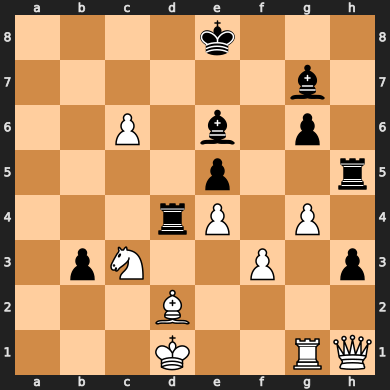

In [83]:
board

In [84]:
board_representation(board)[:,:,2] # the encoding of the positions of black Bishop using the Alpha Zero encoding

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [86]:
board_encoder(board)[:,:,8] # the encoding of the positions of black Bishop using my simplified encoding

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [88]:
np.all(board_representation(board)[:,:,2] == board_encoder(board)[:,:,8]) # these two encoding should be the same

True

#TensorFlow

In [11]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers

In [12]:
def build_model(conv_size, conv_depth):
  input = layers.Input(shape=(8,8,15))
  # adding the convolutional layers
  x = input
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  
  return models.Model(inputs=input, outputs=x)

In [23]:
model = build_model(256, 4)
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


randomly generated data...

In [111]:
# dataset_board = []
# dataset_v = []
# for i in tqdm(range(100000)):
#   board = random_board()
#   v = stockfish(board, 3)
#   if v is not None:
#     dataset_board.append(board_encoder_yt(board))
#     dataset_v.append(v)
# dataset_board = np.array(dataset_board, dtype=np.int8)
# dataset_v = np.array(dataset_v, dtype=np.int64)
# np.savez(r"C:\Users\Richard.Huang\OneDrive - TGS\Desktop\Jupyter\AlphaZero\dataset.npz", X=dataset_board, y=dataset_v)

100%|██████████| 100000/100000 [5:41:26<00:00,  4.88it/s]  


Load data from lichess...

In [19]:
def read_pgn_zst(file_path):
  pgn_data = {}
  with open(file_path, 'rb') as f:
    decompressor = zstandard.ZstdDecompressor()
    with decompressor.stream_reader(f) as reader:
      text_stream = io.TextIOWrapper(reader, encoding='utf-8')
      counter_total = 0
      counter = 0
      for line in text_stream:
        counter += 1
        counter_total += 1
        data = json.loads(line)
        pgn_data[counter] = data
        if counter % 1000000 == 0:
          merged_json = json.dumps(pgn_data)
          with open(r"C:\Users\Richard.Huang\OneDrive - TGS\Desktop\Jupyter\AlphaZero\lichess_db_eval."+str(counter // 1000000)+".json", 'w') as output:
            output.write(merged_json)
          pgn_data = {}
      print(f"Loaded {counter_total} FEN positions")
      # data = json.loads(''.join(board_data))
      # for line in reader.read():
      #   print(line)
      #   break
  #     for line in reader:
  #       pgn_data.append(line.decode())
  # return pgn_data

In [20]:
read_pgn_zst(r"C:\Users\Richard.Huang\OneDrive - TGS\Desktop\Jupyter\AlphaZero\lichess_db_eval.jsonl.zst")

Loaded 20999267 FEN positions


In [89]:
with open(r"C:\Users\Richard.Huang\OneDrive - TGS\Desktop\Jupyter\AlphaZero\lichess_db_eval.1.json", 'r') as json_file:
  lichessdata = json.load(json_file)

In [108]:
lichessdata['108170']

{'fen': '2r4b/P3P2p/P3p2P/P1BpPpPk/Pp1PbP2/bP1Np1P1/BRK1PpbP/NQRB4 w - -',
 'evals': [{'pvs': [{'cp': 0,
     'line': 'e7e8q c8e8 a7a8q e8a8 g5g6 h5g6 g3g4 f5g4 f4f5 e6f5'},
    {'mate': -10,
     'line': 'e7e8b h5g4 e8h5 g4h5 a7a8q f2f1q a8c8 f1e1 c8e8 h5g4'},
    {'mate': -10,
     'line': 'a7a8b c8a8 e7e8b a8e8 a6a7 f2f1q a7a8q e8a8 g3g4 h5h4'},
    {'mate': -10,
     'line': 'a7a8q c8a8 e7e8b a8e8 a6a7 f2f1q a7a8q e8a8 g3g4 h5h4'},
    {'mate': -9,
     'line': 'g3g4 h5g4 h2h3 g4h4 a7a8q c8a8 e7e8r a8e8 a6a7 f2f1q'}],
   'knodes': 3283,
   'depth': 18}]}

In [145]:
dataset_board = []
dataset_v = []
counter = 0
for game in tqdm(lichessdata):
  counter += 1
  board = chess.Board(fen=lichessdata[game]['fen'])
  v = stockfish(board, 3)
  if v is not None:
    dataset_board.append(board_encoder(board))
    dataset_v.append(v)
  if counter % 100000 == 0:
    dataset_board = np.array(dataset_board, dtype=np.int8)
    dataset_v = np.array(dataset_v, dtype=np.int16)
    np.savez(r"C:\Users\Richard.Huang\OneDrive - TGS\Desktop\Jupyter\AlphaZero\dataset_lichess"+str(counter // 100000)+".Mar18.npz", X=dataset_board, y=dataset_v)
    dataset_board = []
    dataset_v = []

 30%|███       | 302121/1000000 [18:43:16<43:14:41,  4.48it/s]  


ValueError: invalid en passant part in fen: 'r4rk1/pp1b1ppp/2n1p3/2qp4/8/2PBP3/PP1N1PPP/R2QK2R w Q f'

In [125]:
board = chess.Board(fen='2r4b/P3P2p/P3p2P/P1BpPpPk/Pp1PbP2/bP1Np1P1/BRK1PpbP/NQRB4 w - -')

In [140]:
# dataset_board = []
# dataset_v = []
board = chess.Board(fen=lichessdata['108170']['fen'])
# v = stockfish(board, 3)
# if v is not None:
#   # dataset_board.append(board_encoder(board))
#   board_encoder(board)
#   dataset_v.append(v)
# 
fen = board.fen()
fen_field = fen.split(' ')
PiecePlacement = fen_field[0].split('/')
piece_dict = {"R":0, "N":1, "B":2, "Q":3, "K":4, "P":5,
              "r":6, "n":7, "b":8, "q":9, "k":10, "p":11
              }
# for rank in range(8):
#   pieces = ''
#   for c in PiecePlacement[rank]:
#     if c.isnumeric():
#       pieces += '-'*int(c)
#     else:
#       pieces += c
#   for file in range(8):
#     if pieces[file] != '-':
#       encoded_board[rank, file, piece_dict[pieces[file]]] = 1
# plane 12 encodes all the legal moves of white
# aux = board.turn
# board.turn = chess.WHITE
for move in board.legal_moves:
  encoded_board[7-np.unravel_index(move.to_square, (8,8))[0], np.unravel_index(move.to_square, (8,8))[1], 12] = 1
  # plane 13 encodes all the legal moves of black
board.turn = chess.BLACK
for move in board.legal_moves:
  encoded_board[7-np.unravel_index(move.to_square, (8,8))[0], np.unravel_index(move.to_square, (8,8))[1], 13] = 1
# board.turn = aux
# plane 14 encodes the current player to move: white is 1, black is 0
# if fen_field[1] == 'w':
#   encoded_board[:,:,14] = 1
# else:
#   encoded_board[:,:,14] = 0
# board_encoder(chess.Board(fen=lichessdata['108170']['fen']))

In [50]:
for i in range(1, 10):
  print(data[str(i)])

{'fen': 'rn1q1rk1/pbp2ppp/1p1bp3/8/3Pp3/1P2PN2/PBPN1PPP/R2Q1RK1 w - -', 'evals': [{'pvs': [{'cp': -38, 'line': 'f3e5 b8a6 e5c4 d6e7 d1e2 c7c5 a1d1 d8c7 d2b1 c5d4'}, {'cp': -90, 'line': 'f3e1 d8h4 f2f4 b8d7 a2a4 a7a5 d2c4 d7f6 c2c3 b7a6'}], 'knodes': 7825, 'depth': 20}]}
{'fen': '3R4/p4pkp/3p2p1/2pP4/3brP2/P5PP/P2B4/7K b - -', 'evals': [{'pvs': [{'cp': -133, 'line': 'e4e2 d2a5 e2e3 h1g2 e3a3 a5c7 a3a2 g2f3 a2a3 f3g2'}, {'cp': -87, 'line': 'g7f6 d8d6 f6e7 d6c6 f7f6 a3a4 e7d7 d2a5 e4e3 h1g2'}, {'cp': -71, 'line': 'd4f6 d8d6 e4e2 d2a5 e2a2 d6c6 a2a3 c6c5 a3g3 h1h2'}], 'knodes': 2581, 'depth': 20}]}
{'fen': 'rn3rk1/1b3ppp/p3pn2/1p6/1P6/1BB1PN2/1P3PPP/3RK2R w K -', 'evals': [{'pvs': [{'cp': 24, 'line': 'c3f6 g7f6 f3d4 b8c6 d4c6 b7c6 f2f3 f6f5 e1f2 f8c8'}, {'cp': 20, 'line': 'f3e5 b7d5 b3d5 f6d5 e1e2 f8c8 d1c1 f7f6 e5d3 d5c3'}, {'cp': 20, 'line': 'e1e2 f8c8 f3e5 b7d5 b3d5 f6d5 d1c1 f7f6 e5d3 d5c3'}, {'cp': 17, 'line': 'f3d4 f6e4 d1c1 f8c8 f2f3 e4c3 c1c3 c8c3 b2c3 b8c6'}, {'cp': 9, 'line': 'f3

In [74]:
with chess.engine.SimpleEngine.popen_uci(r"C:\Users\Richard.Huang\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe") as sf:      
  print(sf.analyse(board, chess.engine.Limit(depth=3)))
  print(sf.analyse(board, chess.engine.Limit(depth=3))['score'].black())

{'string': 'NNUE evaluation using nn-b1a57edbea57.nnue', 'depth': 3, 'seldepth': 2, 'multipv': 1, 'score': PovScore(Cp(-16), WHITE), 'nodes': 100, 'nps': 100000, 'hashfull': 0, 'tbhits': 0, 'time': 0.001, 'pv': [Move.from_uci('f3e1')]}
+15


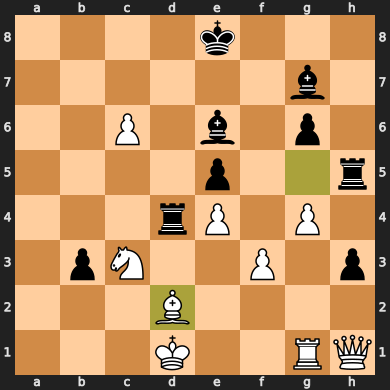

In [37]:
board

In [64]:
import tensorflow.keras.callbacks as callbacks

In [112]:
dataset = np.load(r"C:\Users\Richard.Huang\OneDrive - TGS\Desktop\Jupyter\AlphaZero\dataset.npz")

In [115]:
X = dataset['X']
y = dataset['y']

In [114]:
X.shape

(93383, 8, 8, 14)

In [116]:
y = np.array(y / abs(y).max()/2 + 0.5, dtype=np.float32)

In [82]:
model.compile(optimizer=optimizers.Adam(1e-3), loss='mean_squared_error')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 8, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 256)      │        32,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851,457 (10.88 MB)

 Trainable params: 2,851,457 (10.88 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
model.fit(X, y,
          batch_size=2048,
          epochs=100,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10), 
                     callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5, verbose=1, restore_best_weights=True)])

model.save(r"C:\Users\Richard.Huang\OneDrive - TGS\Desktop\Jupyter\AlphaZero\model2_10kdata.keras")

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 302s 7s/step - loss: 0.0075 - val_loss: 0.0061 - learning_rate: 1.0000e-05
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 325s 8s/step - loss: 0.0061 - val_loss: 0.0058 - learning_rate: 1.0000e-05
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 332s 8s/step - loss: 0.0059 - val_loss: 0.0057 - learning_rate: 1.0000e-05
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 412s 10s/step - loss: 0.0057 - val_loss: 0.0056 - learning_rate: 1.0000e-05
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 406s 10s/step - loss: 0.0056 - val_loss: 0.0055 - learning_rate: 1.0000e-05
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 437s 10s/step - loss: 0.0055 - val_loss: 0.0054 - learning_rate: 1.0000e-05
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 398s 9s/step - loss: 0.0055 - val_loss: 0.0054 - learning_rate: 1.0000e-05
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 326s 8s/step - loss: 0.0055 - val_loss: 0.0053 - learning_rate: 1.0000e-05
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 330s 8s/step - loss: 0.0054 - val_loss: 0.0053

#Playing

In [118]:
def minimax_eval(board):
  board_rep = board_encoder(board)
  board_rep = np.expand_dims(board_rep, axis=0)
  return model.predict(board_rep, verbose=0)[0][0]

def minimax(board, depth, alpha, beta, maximizing=False):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  if maximizing: # maximizing the value
    max_val = -np.inf
    for move in board.legal_moves:
      board.push(move)
      val = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_val = max(max_val, val)
      alpha = max(alpha, val)
      if beta <= alpha:
        break
    return max_val
  else:
    min_val = np.inf
    for move in board.legal_moves:
      board.push(move)
      val = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_val = min(min_val, val)
      beta = min(beta, val)
      if beta <= alpha:
        break
    return min_val

def get_ai_move(board, depth):
  max_move = None
  max_val = -np.inf
  
  for move in board.legal_moves:
    board.push(move)
    val = minimax(board, depth - 1, -np.inf, np.inf, False)
    board.pop()
    if val > max_val:
      max_val = val
      max_move = move
      
  return max_move
    

In [120]:
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci(r"C:\Users\Richard.Huang\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe") as sf:
  while True:
    move = get_ai_move(board, 2)
    board.push(move)
    print('\nWhite plays...')
    print(board)
    if board.is_game_over():
      break
        
    move = sf.analyse(board, chess.engine.Limit(time=1))['pv'][0]
    board.push(move)
    print('\nBlack plays...')
    print(board)
    if board.is_game_over():
      break


White plays...
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

Black plays...
r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

White plays...
r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P N P P P
R N B Q K B . R

Black plays...
r n b q k b . r
p p . p p p p p
. . . . . n . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P N P P P
R N B Q K B . R

White plays...
r n b q k b . r
p p . p p p p p
. . . . . n . .
. . p . . . . .
. . . . P . . .
. . N . . . . .
P P P P N P P P
R . B Q K B . R

Black plays...
r n b q k b . r
p p . . p p p p
. . . . . n . .
. . p p . . . .
. . . . P . . .
. . N . . . . .
P P P P N P P P
R . B Q K B . R

White plays...
r n b q k b . r
p p . . p p p p
. . . . . n . .
. . p p P . . .
. . . . . . . .
. . N . . . . .
P P P P N P P P
R . B Q 